In [1]:
import pandas as pd, numpy as np
from datetime import date
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt

#https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory
#https://www.kaggle.com/mczielinski/bitcoin-historical-data


#CRYPTOCURRENCY PRICE HISTORY

bitcoin_dataset = pd.read_csv('bitcoin_dataset.csv')
bits =bitcoin_dataset[['Date','btc_market_price']]
bits.rename(columns={'btc_market_price':'Close'},inplace=True)
bits = bits[bits['Close']>0]
bits['Date'] = pd.to_datetime(bits['Date'])
bits_indexed = bits.set_index('Date')
data = bits_indexed['Close']



def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries,regression = 'ct', autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print dfoutput
    return dfoutput


/Users/main/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/main/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


We define transform the data to be stationary

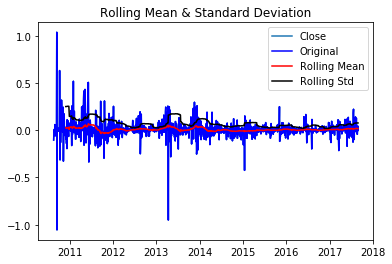

Results of Dickey-Fuller Test:


Test Statistic                -6.949747e+00
p-value                        1.835300e-08
#Lags Used                     1.500000e+01
Number of Observations Used    1.267000e+03
Critical Value (5%)           -3.413961e+00
Critical Value (1%)           -3.965933e+00
Critical Value (10%)          -3.129093e+00
dtype: float64

In [2]:
bits_log = np.log(data)
bits_log_shift = bits_log - bits_log.shift()
bits_log_shift.dropna(inplace=True)
plt.plot(bits_log_shift)
test_stationarity(bits_log_shift)

We transform the data to be supervised learning

In [3]:
from pandas import DataFrame
from pandas import concat
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

X = bits_log_shift.values
supervised = timeseries_to_supervised(X,1)
supervised_values = supervised.values

We split the set up into a train set and a test set

In [4]:
train, test = supervised_values[0:-7], supervised_values[-7:]

We scale the data so it is compatable with the activation function

In [5]:
from sklearn.preprocessing import MinMaxScaler
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0],train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0],test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

scaler, train_scaled, test_scaled = scale(train, test)

Now fit the model

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model


lstm_model = fit_lstm(train_scaled,1,3,4)
train_reshaped = train_scaled[:,0].reshape(len(train_scaled),1,1)

Using TensorFlow backend.


Forecast the entire training data set to build up state for forecasting

In [7]:
train_reshaped = train_scaled[:,0].reshape(len(train_scaled),1,1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.0131715 ],
       [ 0.01243987],
       [ 0.01721993],
       ..., 
       [ 0.02381097],
       [ 0.02008167],
       [ 0.02242926]], dtype=float32)

Walk Forward in validation on the test data

In [17]:
import numpy as np

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return np.exp(yhat)*history[-interval]


predictions = []
for i in range(len(test_scaled)):
    #Make one step forecast
    X, y = test_scaled[i,0:-1], test_scaled[i,-1]
    yhat = forecast_lstm(lstm_model,1,X)
    #invert scaling
    yhat = invert_scale(scaler, X, yhat)
    #invert differencing
    yhat = inverse_difference(data, yhat, len(test_scaled)+1-i)
    #store forecast
    predictions.append(yhat)
    expected = data[len(train)+i]
    print('day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

day=1, Predicted=4200.101898, Expected=4125.548020
day=2, Predicted=4278.446492, Expected=4217.028329
day=3, Predicted=4386.557686, Expected=4328.725717
day=4, Predicted=4269.320434, Expected=4222.662214
day=5, Predicted=4084.062755, Expected=4043.722000
day=6, Predicted=4229.626571, Expected=4174.950000
day=7, Predicted=4426.978075, Expected=4363.054450


In [19]:
pred = pd.Series(predictions, index = data[-7:].index)

In [20]:
from matplotlib import pyplot as plt
rmse = np.sqrt(mean_squared_error(data[-7:], predictions))
print ('Test RMSE: %.3f' % rmse)

Test RMSE: 126.443


In [22]:
fittedvalues_neural = pd.Series(lstm_model.fittedvalues, copy=True)
fitcumsum_neural = fittedvalues_neural.cumsum()
predictions_neural_log = pd.Series(bits_log.iloc[0], index=bits_log.index)
predictions_neural_log = predictions_neural_log.add(fitcumsum,fill_value=0)
predictions_neural = np.exp(predictions_neural_log)

fig, ax = plt.subplots(figsize=(10,5))

plt.plot(data,label='Actual Bitcoin Price')
plt.plot(predictions_neural,color = 'red',label='Neural Net Recursion Model')
ax.set(title='The curve of Bitcoin price and the curve of the fitted data, ',\
         xlabel='Year', ylabel='Bitcoin value in USD')
print ('Root mean square error: %.4f'% np.sqrt(sum((predictions_neural-data)**2)/len(data)))
legend = ax.legend(loc='center')
plt.show()

AttributeError: 'Sequential' object has no attribute 'fittedvalues'

Report performance

Test RMSE: 126.443


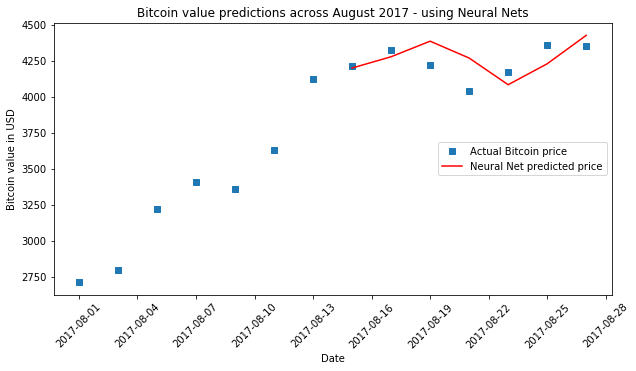

In [21]:
from matplotlib import pyplot as plt
rmse = np.sqrt(mean_squared_error(data[-7:], predictions))
print ('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted

fig, ax = plt.subplots(figsize=(10,5))
ax.set(title='Bitcoin value predictions across August 2017 - using Neural Nets', \
       xlabel='Date', ylabel='Bitcoin value in USD', label=str(rmse))
ax.plot(data[-14:], 's', label='Actual Bitcoin price')
ax.plot(pred, 'r', label='Neural Net predicted price')
legend = ax.legend(loc='center right')
plt.xticks(rotation=45)
plt.show()